# averaging videos


## load one video

In [1]:
output_folder = 'out'
fname = 'traveling-slowly-through-an-ice-cave.mp4'
vname = f'{output_folder}/{fname}'
url = 'https://www.istockphoto.com/en/video/traveling-slowly-through-an-ice-cave-and-exiting-the-other-side-onto-a-beautiful-gm1300340943-392699878'

In [2]:
# 1. install Xcode:
# From this url : (uncomment the following line)
# open http://itunes.apple.com/us/app/xcode/id497799835?mt=12
# install Xcode on the Mac App Store by clicking on “View in Mac App Store”.
# or simply use the following line:
# xcode-select --install
#sudo rm -rf /Library/Developer/CommandLineTools
# !sudo xcode-select --install

# 2. install HomeBrew
# !/bin/bash -c "$(curl -fsSL https://raw.githubusercontent.com/Homebrew/install/HEAD/install.sh)"

# !brew install yt-dlp

In [3]:
! mkdir -p {output_folder}

import os
if not os.path.isfile(vname):
    ! yt-dlp {url} --output {vname}

## read video

In [4]:
!python3.11 -m pip install --upgrade pip av imageio matplotlib

In [5]:
# %conda install av
# %pîp install av

https://imageio.readthedocs.io/en/stable/examples.html#read-or-iterate-frames-in-a-video

In [6]:
import imageio.v3 as iio

# bulk read all frames
# Warning: large videos will consume a lot of memory (RAM)
frames = iio.imread(vname, plugin="pyav")


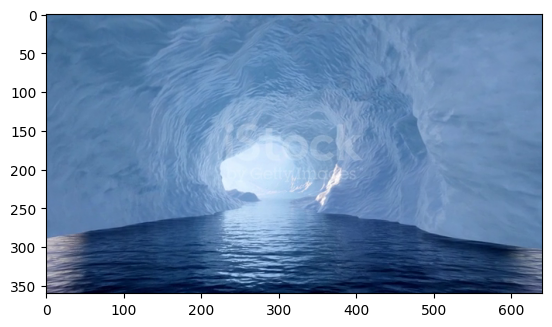

In [7]:
import matplotlib.pyplot as plt
i_image = 42
plt.imshow(frames[i_image, :, :, :])

In [8]:
frames.shape

(900, 360, 640, 3)

In [9]:
DS = 1 # spatial downscaling
frames = frames[:, ::DS, ::DS, :]

In [10]:
frames.shape

(900, 360, 640, 3)

## mix time slices from the video

In [11]:
import numpy as np

In [12]:
def full_contrast(image):
    return (image - image.min()) / (image.max() - image.min())
N_T=120


In [13]:
# from tqdm.notebook import trange
from tqdm import trange
N_average = 1200
def mix(frames, N_average=N_average, N_T=N_T, do_loop=True):

    N_T_total, N_X, N_Y, three = frames.shape
    frames_mean = np.zeros((N_T, N_X, N_Y, three))
    if do_loop:
        mask = np.ones((N_T, N_X, N_Y, three))
        mask *= 1 - np.abs(np.linspace(-1, 1, N_T))[:, None, None, None]
    for _ in trange(N_average):
        N_T_shift = np.random.randint(N_T_total - N_T)
        frames_new = frames[N_T_shift:(N_T_shift+N_T), ...]
        if do_loop:
            frames_mean += frames_new * mask
            frames_mean += np.roll(frames_new, shift=N_T//2, axis=0) * (1-mask)
        else:
            frames_mean += frames_new

    return full_contrast(frames_mean)

In [14]:
out_vname = f'{output_folder}/loop_{fname}'

if not os.path.isfile(out_vname):
    iio.immeta(vname, plugin="pyav")
    fps = np.ceil(iio.immeta(vname, plugin="pyav")["fps"])
    frames_mean = mix(frames, N_average=N_average, N_T=120)

    with iio.imopen(out_vname, "w", plugin="pyav") as out_file:
        out_file.init_video_stream("h264", fps=fps)
        for i_frame in range(N_T):
            out_file.write_frame((frames_mean[i_frame, ...]*255).astype(np.uint8))

/usr/local/lib/python3.11/site-packages/imageio/plugins/pyav.py:725: UserWarning: PyAV 10.0.0 has known issues reading metadata. If you need video metadata consider using v9.2.0 instead.
  warnings.warn(
100%|██████████| 1200/1200 [22:22<00:00,  1.12s/it]
